In [1]:
import os 
os.chdir('../')
from src.datasets.dataloader import get_dataset 
import ml_collections

import yaml
import torch
from os import path as pt
from src.utils import get_experiment_dir, save_obj
from src.evaluations.plot import predictive_score_plot

/home/hanglou/ac3/envs/PathChar_GAN/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_dir = 'configs/' + 'train_gan.yaml'
with open(config_dir) as file:
        config = ml_collections.ConfigDict(yaml.safe_load(file))
config.dataset = 'GBM'
config.algo = 'RCGAN'
#create train and test dataloader.
train_dl, test_dl = get_dataset(config, num_workers=4)

from src.baselines.models import get_trainer
trainer = get_trainer(config, train_dl, test_dl)
get_experiment_dir(config)
generator = trainer.G
generator.load_state_dict(torch.load(pt.join(
            config.exp_dir, 'generator_state_dict.pt'))) # load trained generator


# generate some fake data
from src.evaluations.evaluations import *
real_data = torch.cat([loader_to_tensor(train_dl),
                          loader_to_tensor(test_dl)])
idx = torch.randint(real_data.shape[0], (10000,))
real_test_dl = DataLoader(TensorDataset(
            real_data[idx[-2000:]]), batch_size=128)
fake_test_dl = fake_loader(generator, num_samples=2000,
                                n_lags=config.n_lags, batch_size=128, config=config)
x_real, x_fake = loader_to_tensor(real_test_dl), loader_to_tensor(fake_test_dl)
real_train_dl = DataLoader(TensorDataset(
            real_data[idx[:-2000]]), batch_size=128)
fake_train_dl = fake_loader(generator, num_samples=8000,
                                        n_lags=config.n_lags, batch_size=128, config=config)

data shape: torch.Size([64, 50, 2])
RCGAN
GBM_RCGAN
GENERATOR: LSTMGenerator(
  (rnn): LSTM(5, 32, num_layers=3, batch_first=True)
  (linear): Linear(in_features=32, out_features=2, bias=True)
  (initial_nn): Sequential(
    (0): ResFNN(
      (network): Sequential(
        (0): ResidualBlock(
          (linear): Linear(in_features=5, out_features=32, bias=True)
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (1): ResidualBlock(
          (linear): Linear(in_features=32, out_features=32, bias=True)
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (2): Tanh()
        (3): Linear(in_features=32, out_features=96, bias=True)
      )
    )
    (1): Tanh()
  )
  (initial_nn1): Sequential(
    (0): ResFNN(
      (network): Sequential(
        (0): ResidualBlock(
          (linear): Linear(in_features=5, out_features=32, bias=True)
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (1): ResidualBlock(
          (linear): Li

In [6]:
epochs_grid = [10*i for i in range(1,11)] 
df = predictive_score_plot(real_train_dl, real_test_dl, fake_train_dl, fake_test_dl, config, epochs_grid)

predictor(
  (rnn): LSTM(2, 20, batch_first=True)
  (linear): Linear(in_features=20, out_features=10, bias=True)
)
Epoch 1/10
------------------------------
train Loss: 0.7012
validation Loss: 0.4559
Epoch 2/10
------------------------------
train Loss: 0.3921
validation Loss: 0.3485
Epoch 3/10
------------------------------
train Loss: 0.2610
validation Loss: 0.2177
Epoch 4/10
------------------------------
train Loss: 0.1847
validation Loss: 0.1832
Epoch 5/10
------------------------------
train Loss: 0.1614
validation Loss: 0.1697
Epoch 6/10
------------------------------
train Loss: 0.1498
validation Loss: 0.1622
Epoch 7/10
------------------------------
train Loss: 0.1427
validation Loss: 0.1573
Epoch 8/10
------------------------------
train Loss: 0.1378
validation Loss: 0.1537
Epoch 9/10
------------------------------
train Loss: 0.1343
validation Loss: 0.1512
Epoch 10/10
------------------------------
train Loss: 0.1314
validation Loss: 0.1493
Best Val MSE: 0.1493
predictor(
  

In [7]:
df

,epochs,predictive score
0,10,0.149
1,10,0.149
2,10,0.148
3,20,0.142
4,20,0.141
5,20,0.141
6,30,0.141
7,30,0.141
8,30,0.140
9,40,0.143


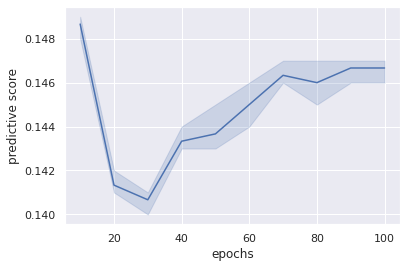

In [10]:
sns.set()
fig = sns.lineplot(data=df, x='epochs', y='predictive score')
plt.savefig('./numerical_results/predictive_score.png', dpi=250)